In [1]:
# install dependency for Google Colab
!pip install onedrivedownloader

In [2]:
from datetime import timedelta
import math
from time import time
import os
import shutil
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from PIL import Image

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import *
from sklearn.svm import *
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import *
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

import torch.nn as nn
import torch.optim as optim
import torch
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F

from onedrivedownloader import download

# Fitting a function

## Plotting a curve

In [3]:
granularity = 0.05
x = np.arange(0, 2*np.pi, granularity).reshape(-1, 1)
y = np.sin(x).reshape(-1, 1)

In [4]:
len(x)

126

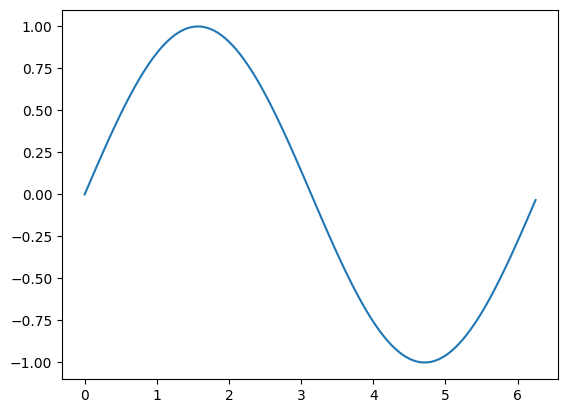

In [5]:
plt.plot(x, y)
plt.show()

In [6]:
# TODO: sample out some training data and add a bit of noise to it
# If numpy array indexing  is new to you, take a look at this: https://www.geeksforgeeks.org/numpy-indexing/
# tl;dr: we can select a single index by providing a single index n arr[n],
# but we can also select multiple elements of an array, by providing multiple indices n, o, p arr[[n, o, p]]

# select random indices
idx_train = np.random.choice(len(x), size=25) # Docs: https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
x_train = x[idx_train]
# add noise, as real world data is rarely perfect
y_train = y[idx_train] + np.random.normal(loc=0, scale=0.1, size=(len(idx_train), 1)) # Docs: https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html

In [7]:
len(x_train)

25

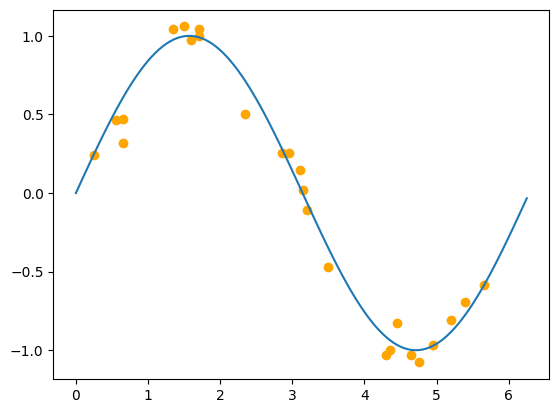

In [8]:
# TODO: plot the training data with the original sine curve
plt.plot(x, y)
plt.scatter( x_train, y_train, color='orange') # Docs: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
plt.show()

## Learning a curve

In [9]:
# TODO: what classifiers could we try? Can you find more sklearn regressors that work better?
# Can we improve them by changing the hyperparamters? (for instance the hidden_layer_sizes in the MLPRegressor)
classifiers = [
    RandomForestRegressor(), # Docs: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
    LinearRegression(), # Docs: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
    MLPRegressor(), # Docs: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor
]

RandomForestRegressor()


<ipython-input-10-5cba44ec1c6b>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit( x_train, y_train)


0.9359354241182574


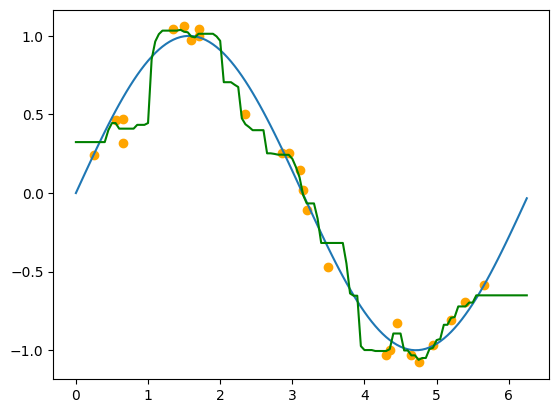

LinearRegression()
0.5491671233637216


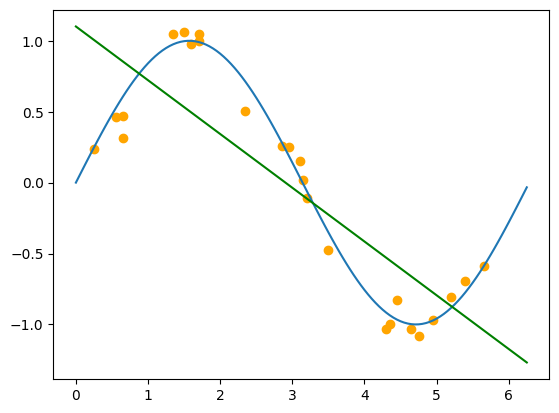

MLPRegressor()


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7294685361550305


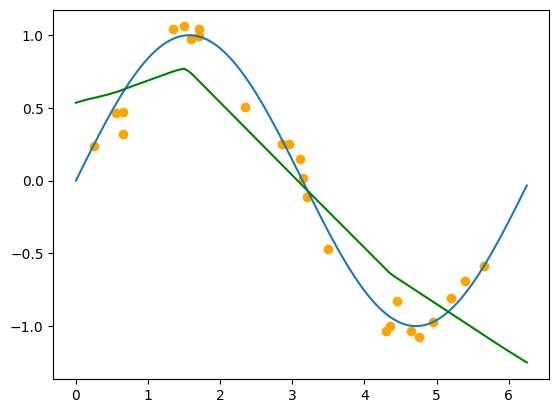

In [10]:
for clf in classifiers:
  # TODO: train the classifier and evaluate it. We want to find the best one.
  # How can we see the performance of a classifier?
  print(clf)

  clf.fit( x_train, y_train)
  score = clf.score( x, y)
  print(score)
  y_pred = clf.predict(x)

  # TODO: plot sine, train data, and prediction
  plt.plot(x, y)
  plt.scatter( x_train, y_train, color='orange')
  plt.plot( x, y_pred, color='green')
  plt.show()


# Image classification example: Character recognition

## Import data

In [11]:
mnist_dataset = MNIST(root = 'data_mnist/', train=True, download=True, transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5423228.45it/s]


Extracting data_mnist/MNIST/raw/train-images-idx3-ubyte.gz to data_mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 156703.26it/s]


Extracting data_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data_mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1510034.79it/s]


Extracting data_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data_mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 749253.86it/s]


Extracting data_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data_mnist/MNIST/raw



In [12]:
len(mnist_dataset)

60000

In [13]:
train_data, test_data = random_split(mnist_dataset, [0.8, 0.2])

In [14]:
print(len(train_data))
print(len(test_data))

48000
12000


In [15]:
# data loaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

## Plotting

Label: 0


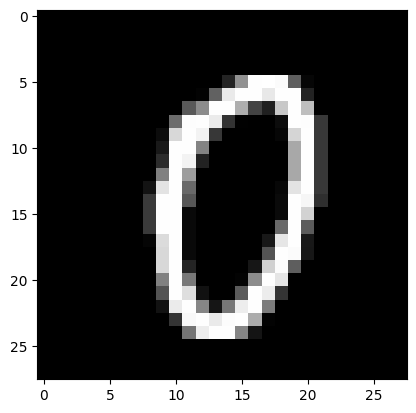

In [16]:
image, label = mnist_dataset[1000]
plt.imshow(transforms.ToPILImage()(image), cmap='gray')
print('Label:', label)

## Training

In [17]:
class MnistModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(28*28, 10)

  def forward(self, x):
    x = self.flatten(x)
    x = F.softmax(self.linear(x))
    return x


In [18]:
def train(model, device, train_loader, optimizer, criterion, epochs, test_loader=None):
  for epoch in range(epochs):
    start = time()

    n_correct = 0
    n_total = 0
    for data, target in tqdm(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()

      n_correct += torch.sum(torch.argmax(output, dim=1) == target).item()
      n_total += len(output)
    train_acc = n_correct / n_total

    print(f'Epoch: {epoch} Loss: {loss.item():.2f} Train acc: {train_acc:.2f}', end='')

    n_correct = 0
    n_total = 0
    if test_loader:
      with torch.no_grad():
        for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          n_correct += torch.sum(torch.argmax(output, dim=1) == target).item()
          n_total += len(output)
      test_acc = n_correct / n_total
      print(f' Test acc: {test_acc:.2f}', end='')

    stop = time()

    print(f' Time: {timedelta(seconds=stop-start)}')
    print()

In [19]:
device_id = 'cpu'
if torch.cuda.is_available(): # check for nvidia gpu
    device_id = 'cuda'
elif torch.backends.mps.is_available(): # check for apple gpu
    device_id = 'mps'
device = torch.device(device_id)
print(device)

cpu


In [21]:
model = MnistModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train(model, device, train_loader, optimizer, criterion, 10, test_loader=test_loader)

  0%|          | 0/375 [00:00<?, ?it/s]

<ipython-input-17-4497efa0384c>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.linear(x))


Epoch: 0 Loss: 1.63 Train acc: 0.79 Test acc: 0.88 Time: 0:00:11.507631



  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 1 Loss: 1.58 Train acc: 0.89 Test acc: 0.90 Time: 0:00:14.163418



  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 2 Loss: 1.60 Train acc: 0.90 Test acc: 0.91 Time: 0:00:11.647292



  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 3 Loss: 1.57 Train acc: 0.91 Test acc: 0.91 Time: 0:00:12.144153



  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 4 Loss: 1.55 Train acc: 0.91 Test acc: 0.91 Time: 0:00:11.061923



  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 5 Loss: 1.56 Train acc: 0.92 Test acc: 0.92 Time: 0:00:11.247956



  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 6 Loss: 1.60 Train acc: 0.92 Test acc: 0.92 Time: 0:00:09.911735



  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 7 Loss: 1.57 Train acc: 0.92 Test acc: 0.92 Time: 0:00:11.061853



  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 8 Loss: 1.53 Train acc: 0.92 Test acc: 0.92 Time: 0:00:10.155000



  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 9 Loss: 1.55 Train acc: 0.93 Test acc: 0.92 Time: 0:00:10.028171



# Finding our lost red dots

## Import data

In [22]:
# definition of some utility functions to import the data
class ImageDataset(Dataset):
  def __init__(self, root_dir, transform=None, size=None, random_seed=42):
    self.root_dir = root_dir
    self.transform = transform
    self.random = random.Random(random_seed)
    self.files = os.listdir(self.root_dir)
    if size:
      if len(self.files) < size:
        raise Exception(f'Only found {len(self.files)} files in root directory, but the requested dataset size is {size}')
      self.files = self.random.sample(self.files, size)

  def __getitem__(self, idx):
    filename = self.files[idx]
    img_path = os.path.join(self.root_dir, filename)
    img = Image.open(img_path)
    img = self.transform(img) if self.transform is not None else img

    dot_count = torch.tensor([int(filename.split('_')[0])])

    return img, dot_count

  def __len__(self):
    return len(self.files)

def prepare_data(path, size=1000, transform=None, batch_size=128, shuffle=True):
  if transform is None:
    transform = transforms.ToTensor()

  dataset = ImageDataset(root_dir=path, transform=transform, size=size)
  dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)
  return dataloader, dataset

def download_data_dots(root='data_dots'):
  url = 'https://goforeoy-my.sharepoint.com/:u:/g/personal/sebastian_landl_gofore_com/EcD5rowDcglFp6j1lSHRI2MBL2bPNssdXGyNRxEeh8cvRA'
  filename = 'data_dots.zip'

  if os.path.exists(root):
    print(f'Folder {root} already exists. Not downloading.')
    return
  download(url, filename=filename, unzip=True, unzip_path=root, clean=True)

In [23]:
# This cell downloads the data and unpacks it into the folder structure defined above
download_data_dots()

Folder data_dots already exists. Not downloading.


In [35]:
# data parameters; here we specify the amount of data to load. More data may improve our model in exchange for longer training times.
train_data_size = 50_000
test_data_size = 5_000
train_data_path = 'data_dots/train'
test_data_path = 'data_dots/test'

In [25]:
train_loader, train_dataset = prepare_data(train_data_path, size=train_data_size, batch_size=128)
test_loader, test_dataset = prepare_data(test_data_path, size=test_data_size, batch_size=128)

## Plotting data

torch.Size([3, 32, 32])
tensor([9])


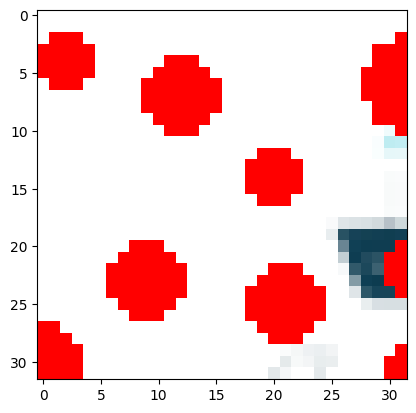

In [26]:
# Let's look at one of the images
x, y = train_dataset[42]
print(x.shape)
print(y)
plt.imshow(transforms.ToPILImage()(x))

## Learning data

In [28]:
# How many of our predictions are correct?
def accuracy(model, device, data_loader):
  n_correct = 0
  n_total = 0
  with torch.no_grad():
    for data, target in data_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      n_correct += torch.sum(torch.round(output) == target).item()
      n_total += len(output)

  return n_correct / n_total

def train(model, device, train_loader, optimizer, criterion, epochs, test_loader=None):
  for epoch in range(epochs):
    start = time()

    n_correct = 0
    n_total = 0
    for data, target in tqdm(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()

      n_correct += torch.sum(torch.round(output) == target).item()
      n_total += len(output)
    train_acc = n_correct / n_total

    print(f'Epoch: {epoch} Loss: {loss.item():.2f} Train acc: {train_acc:.2f}', end='')

    if test_loader:
      test_acc = accuracy(model, device, test_loader)
      print(f' Test acc: {test_acc:.2f}', end='')

    stop = time()

    print(f' Time: {timedelta(seconds=stop-start)}')
    print()

In [29]:
# The training can run on differnt devices
# cpu is the default, as it is always available, but on
# some machines a more specialized device is available
device_id = 'cpu'
if torch.cuda.is_available(): # check for nvidia gpu
    device_id = 'cuda'
elif torch.backends.mps.is_available(): # check for apple gpu
    device_id = 'mps'
device = torch.device(device_id)
print(device)

cpu


Now let's get to training and improving out model.  
You can look into:
- Model architecture
  - [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)  
    The Linear Layer is essentially a matrix that transforms a vector of a given size to another vector of the specified output size.
  - [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)  
    2D convolution is very good for image tasks. It takes one (or more) 2D matrix as an input and creates one (or more) 2D matrix as an output. Our images are basically 3 layers (Red, Green and Blue) of 32 by 32 matrices. [Here](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) are some illustrations of how the convolution operator works on a single layer. Keep in mind that passing data from a 2D convolution layer to a liner layer requires you to flatten the data to a 1D array. You can check out [this website](https://www.baeldung.com/cs/convolutional-layer-size) for an explanation of how to calculate the output size. Depending on what hyperparameters you want to use in the convolution layer and we assume a square image you can start with this simple formula:  
		`conv_out_size = (image_size - conv_kernel_size + 2 * padding) + 1`  
    `linear_layer_in_size = conv_out_channels * conv_out_size * conv_out_size`
- Amount of data
- Number of training iterations
- Any other parameter you can see really

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, image_size=32, num_classes=10):
        super(Model, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(128 * (image_size // 8) * (image_size // 8), 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [36]:
# TODO: run the training, see how your model performs, improve the model
model = Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss() # List of pytorch loss functions: https://neptune.ai/blog/pytorch-loss-functions
train(model, device, train_loader, optimizer, criterion, 10, test_loader=test_loader)

  0%|          | 0/79 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 0 Loss: 0.91 Train acc: 2.32 Test acc: 3.25 Time: 0:00:29.838034



  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 Loss: 0.40 Train acc: 5.82 Test acc: 5.67 Time: 0:00:29.671845



  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 Loss: 0.19 Train acc: 7.52 Test acc: 9.17 Time: 0:00:31.566740



  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 Loss: 0.37 Train acc: 8.89 Test acc: 9.50 Time: 0:00:31.560501



  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 Loss: 0.12 Train acc: 8.85 Test acc: 9.07 Time: 0:00:28.435616



  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 Loss: 0.13 Train acc: 9.78 Test acc: 9.79 Time: 0:00:28.675834



  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 Loss: 0.66 Train acc: 8.63 Test acc: 0.43 Time: 0:00:29.523957



  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 Loss: 0.11 Train acc: 8.75 Test acc: 9.91 Time: 0:00:29.506071



  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 Loss: 0.33 Train acc: 9.79 Test acc: 9.80 Time: 0:00:29.975923



  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 Loss: 0.06 Train acc: 9.90 Test acc: 9.95 Time: 0:00:34.351931



Actual number of dots: 7
Prediction           : 1


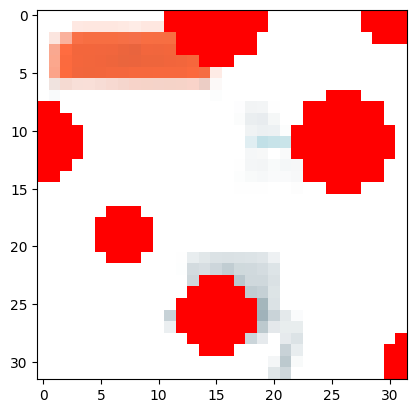

In [32]:
# Let's check one of our images
x, y = test_dataset[42]
with torch.no_grad():
    pred = model(x.unsqueeze(dim=0).to(device))
print('Actual number of dots:', y.item())
predicted_class = pred.argmax(dim=1).item()
print('Prediction           :', predicted_class)
plt.imshow(transforms.ToPILImage()(x))